In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 도입

#### 대출 상점 총 매출 예측 경진대회

#### 데이터 설명 

2016년 12월 14일부터 2018년 7월 30일까지 train data  
2016년 8월 1일부터 2018년 3월 31일까지 test data 


store_id : 각 파일에서의 상점 고유 번호 (해당기한 내 개업 혹은 폐업한 상점도 있음)  
date : 거래일자    
time : 거래 시간   
card_id : 카드 번호의 hash 값  
amount : 매출 금액, 음수인 경우 취소 거래  
installments : 할부 개월 수. 일시불은 빈 문자열   
days_of_week : 요일, 월요일이 0, 일요일은 6  
holiday : 1이면 공휴일, 0이면 공휴일 아님  

total_sales ; 해당 기간의 총 sales (예측)  

#### 2020.12.30 
 
1. 메모리 관리   
    1-1. garbage collection <a href="https://blog.winterjung.dev/2018/02/18/python-gc">참고</a>   
파이썬은 레퍼런스 카운팅 방식으로 메모리를 관리한다. 여기서 발생할 수 있는 순환참조상황을 garbage collection으로 해결한다.    


2. boosting algorithm의 custom objective 와 feval 의 차이.  
    2-1. xgboost custom obj 와 feval <a href="https://changyeon2.tistory.com/6">참고</a>   

3. amount의 음수는 환불. -> 제거하는걸로.   
4. 보통 분류,회귀 생각은 특성들의 train 과 label의 train(X_train,y_train), 그리고 test 인데, 이건 둘다 주는?   

5. 처음 생각  
    혹시나 분류로 가능할까하는 생각에 해봤는데 망했다. 이건 아닌거같다.    
    이동평균과 지수이동평균으로 생각해봐야겠다.   
        
        

In [2]:
# 기본라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# display
from IPython.display import display

# 경고제어
import warnings 
warnings.filterwarnings('ignore')

# 진행상황
from tqdm import tqdm

# 머신러닝
# 전처리
from sklearn.preprocessing import LabelEncoder

# 모델
import xgboost as xgb

In [3]:
# train=pd.read_csv('data01/train.csv',chunksize=50000)
# train=pd.concat(train,ignore_index=True)
# test=pd.read_csv('data01/test.csv',chunksize=50000)
# test=pd.concat(test,ignore_index=True)
# submission=pd.read_csv('data01/submission.csv',chunksize=50000)
# submission=pd.concat(submission,ignore_index=True)

# display(train.head())
# display(test.head())

In [4]:
# 할부 특성 버림. https://www.a-ha.io/questions/41be3cb89c455854894edbd2c92b9d2c 

# train.drop('installments',axis=1,inplace=True)
# test.drop('installments',axis=1,inplace=True)

In [5]:
# fig,ax=plt.subplots(1,1,figsize=(6,4),dpi=200)

# ax.boxplot(train[train.store_id==0].amount,vert=False)

# plt.show()

In [6]:
# train['date']=pd.to_datetime(train.date+' '+train.time)
# train.drop('time',axis=1,inplace=True)

# test['date']=pd.to_datetime(test.date+' '+test.time)
# test.drop('time',axis=1,inplace=True)

In [7]:
# pos_train=train[train.amount>0]
# neg_train=train[train.amount<0]

# removed_train=pd.DataFrame()

# for store in tqdm(range(1800)):
#     pos_store=pos_train[pos_train.store_id==store]
#     neg_store=neg_train[neg_train.store_id==store]
    
#     for idx,neg in neg_store.iterrows():
#         refund_date=neg.date
#         refund_card=neg.card_id
#         refund_amount=np.abs(neg.amount)
        
#         row=pos_store[pos_store.date<=refund_date]
#         row=row[row.card_id==refund_card]
#         row=row[row.amount==np.abs(refund_amount)]
        
#         if len(row)!=0:
#             refund_date=np.max(row.date)
#             remove_data=pos_store[pos_store.date==refund_date]
#             remove_data=remove_data[remove_data.card_id==refund_card]
#             remove_data=remove_data[remove_data.amount==refund_amount]
#             pos_store=pos_store.drop(remove_data.index)
#     removed_train=pd.concat([removed_train,pos_store])
#     print(f"store_id : {store} 끝.")

In [8]:
# print(removed_train.shape)
# display(removed_train.head())

In [9]:
# pos_test=test[test.amount>0]
# neg_test=test[test.amount<0]

# removed_test=pd.DataFrame()

# for store in tqdm(range(180)):
#     pos_store=pos_test[pos_test.store_id==store]
#     neg_store=neg_test[neg_test.store_id==store]
    
#     for idx,neg in neg_store.iterrows():
#         refund_date=neg.date
#         refund_card=neg.card_id
#         refund_amount=np.abs(neg.amount)
        
#         row=pos_store[pos_store.date<=refund_date]
#         row=row[row.card_id==refund_card]
#         row=row[row.amount==np.abs(refund_amount)]
        
#         if len(row)!=0:
#             refund_date=np.max(row.date)
#             remove_data=pos_store[pos_store.date==refund_date]
#             remove_data=remove_data[remove_data.card_id==refund_card]
#             remove_data=remove_data[remove_data.amount==refund_amount]
#             pos_store=pos_store.drop(remove_data.index)
#     removed_test=pd.concat([removed_test,pos_store])
#     print(f"store_id : {store} 끝.")

In [10]:
# print(removed_test.shape)
# display(removed_test.head())

In [11]:
# removed_train.to_csv('data01/pos_train.csv',index=False,encoding='utf-8',chunksize=100000)
# removed_test.to_csv('data01/pos_test.csv',index=False,encoding='utf-8',chunksize=100000)

In [12]:
train=pd.read_csv('/content/drive/MyDrive/colab전용/pos_train.csv',chunksize=100000)
train=pd.concat(train)
test=pd.read_csv('/content/drive/MyDrive/colab전용/pos_test.csv',chunksize=100000)
test=pd.concat(test)

# 읽을 때 object로 읽는다.
train['date']=pd.to_datetime(train['date'])
test['date']=pd.to_datetime(test['date'])
display(test.head())
display(train.head())

,store_id,date,card_id,amount,days_of_week,holyday
0,0,2016-08-01 00:28:15,bf33518373,125,0,0
1,0,2016-08-01 01:09:58,7a19a3a92f,90,0,0
2,0,2016-08-01 01:47:24,6f9fd7e241,150,0,0
3,0,2016-08-01 17:54:43,8bcf1d61b2,362,0,0
4,0,2016-08-01 18:48:53,6a722ce674,125,0,0


,store_id,date,card_id,amount,days_of_week,holyday
0,0,2016-12-19 12:42:31,0880849c05,144,0,0
1,0,2016-12-19 12:48:08,8b4f9e0e95,66,0,0
2,0,2016-12-19 13:31:08,7ad237eed0,24,0,0
3,0,2016-12-19 13:36:39,30b1422f77,44,0,0
4,0,2016-12-19 14:00:23,6dd8dad5ab,146,0,0


In [13]:
# 날짜 특성 변수
train['day']=train['date'].dt.day
train['hour']=train['date'].dt.hour
train['year']=train['date'].dt.year
train['month']=train['date'].dt.month
train['minute']=train['date'].dt.minute

test['day']=test['date'].dt.day
test['hour']=test['date'].dt.hour
test['year']=test['date'].dt.year
test['month']=test['date'].dt.month
test['minute']=test['date'].dt.minute

In [14]:
def minute_band(m):
    if m<30:
        return 'under_30'
    else:
        return 'over_30'
    
# https://m.blog.naver.com/PostView.nhn?blogId=webkim&logNo=221540904258&proxyReferer=https:%2F%2Fwww.google.com%2F
def hour_band(h):
    if h==24 or 0<=h<11:
        return 'before'
    elif 11<=h<=16:
        return 'little'
    else:
        return 'Thetime'

train['minute_band']=train['minute'].map(minute_band)
train['hour_band']=train['hour'].map(hour_band)

test['minute_band']=test['minute'].map(minute_band)
test['hour_band']=test['hour'].map(hour_band)

train['hour_minute']=train['hour_band']+'#'+train['minute_band']
test['hour_minute']=test['hour_band']+'#'+test['minute_band']
display(train.head())
display(test.head())

,store_id,date,card_id,amount,days_of_week,holyday,day,hour,year,month,minute,minute_band,hour_band,hour_minute
0,0,2016-12-19 12:42:31,0880849c05,144,0,0,19,12,2016,12,42,over_30,little,little#over_30
1,0,2016-12-19 12:48:08,8b4f9e0e95,66,0,0,19,12,2016,12,48,over_30,little,little#over_30
2,0,2016-12-19 13:31:08,7ad237eed0,24,0,0,19,13,2016,12,31,over_30,little,little#over_30
3,0,2016-12-19 13:36:39,30b1422f77,44,0,0,19,13,2016,12,36,over_30,little,little#over_30
4,0,2016-12-19 14:00:23,6dd8dad5ab,146,0,0,19,14,2016,12,0,under_30,little,little#under_30


,store_id,date,card_id,amount,days_of_week,holyday,day,hour,year,month,minute,minute_band,hour_band,hour_minute
0,0,2016-08-01 00:28:15,bf33518373,125,0,0,1,0,2016,8,28,under_30,before,before#under_30
1,0,2016-08-01 01:09:58,7a19a3a92f,90,0,0,1,1,2016,8,9,under_30,before,before#under_30
2,0,2016-08-01 01:47:24,6f9fd7e241,150,0,0,1,1,2016,8,47,over_30,before,before#over_30
3,0,2016-08-01 17:54:43,8bcf1d61b2,362,0,0,1,17,2016,8,54,over_30,Thetime,Thetime#over_30
4,0,2016-08-01 18:48:53,6a722ce674,125,0,0,1,18,2016,8,48,over_30,Thetime,Thetime#over_30


In [15]:
# https://ko.wikipedia.org/wiki/%EC%B9%B4%EB%93%9C_%EB%B2%88%ED%98%B8%EC%9D%98_%EA%B5%AC%EC%84%B1

def card_brand(s):
    if s.startswith('0'):
        return '0'
    elif s.startswith('1'):
        return '1'
    elif s.startswith('2'):
        return '2'
    elif s.startswith('3'):
        return '3'
    elif s.startswith('4'):
        return '4'
    elif s.startswith('5'):
        return '5'
    elif s.startswith('6'):
        return '6'
    elif s.startswith('7'):
        return '7'
    elif s.startswith('8'):
        return '8'
    elif s.startswith('9'):
        return '9'
    elif s.startswith('a'):
        return 'a'
    elif s.startswith('b'):
        return 'b'
    elif s.startswith('c'):
        return 'c'
    elif s.startswith('d'):
        return 'd'
    elif s.startswith('e'):
        return 'e'
    elif s.startswith('f'):
        return 'f'

train['card_brand']=train['card_id'].map(card_brand)
test['card_brand']=test['card_id'].map(card_brand)
display(train.head())
display(test.head())

,store_id,date,card_id,amount,days_of_week,holyday,day,hour,year,month,minute,minute_band,hour_band,hour_minute,card_brand
0,0,2016-12-19 12:42:31,0880849c05,144,0,0,19,12,2016,12,42,over_30,little,little#over_30,0
1,0,2016-12-19 12:48:08,8b4f9e0e95,66,0,0,19,12,2016,12,48,over_30,little,little#over_30,8
2,0,2016-12-19 13:31:08,7ad237eed0,24,0,0,19,13,2016,12,31,over_30,little,little#over_30,7
3,0,2016-12-19 13:36:39,30b1422f77,44,0,0,19,13,2016,12,36,over_30,little,little#over_30,3
4,0,2016-12-19 14:00:23,6dd8dad5ab,146,0,0,19,14,2016,12,0,under_30,little,little#under_30,6


,store_id,date,card_id,amount,days_of_week,holyday,day,hour,year,month,minute,minute_band,hour_band,hour_minute,card_brand
0,0,2016-08-01 00:28:15,bf33518373,125,0,0,1,0,2016,8,28,under_30,before,before#under_30,b
1,0,2016-08-01 01:09:58,7a19a3a92f,90,0,0,1,1,2016,8,9,under_30,before,before#under_30,7
2,0,2016-08-01 01:47:24,6f9fd7e241,150,0,0,1,1,2016,8,47,over_30,before,before#over_30,6
3,0,2016-08-01 17:54:43,8bcf1d61b2,362,0,0,1,17,2016,8,54,over_30,Thetime,Thetime#over_30,8
4,0,2016-08-01 18:48:53,6a722ce674,125,0,0,1,18,2016,8,48,over_30,Thetime,Thetime#over_30,6


In [16]:
# card와 엮기

train['card_year']=[card_brand+'#'+str(year) for card_brand,year in zip(train['card_brand'],train['month'])]
test['card_year']=[card_brand+'#'+str(year) for card_brand,year in zip(test['card_brand'],test['month'])]
    
train['card_month']=[card_brand+'#'+str(month) for card_brand,month in zip(train['card_brand'],train['month'])]
test['card_month']=[card_brand+'#'+str(month) for card_brand,month in zip(test['card_brand'],test['month'])]

train['card_day']=[card_brand+'#'+str(day) for card_brand,day in zip(train['card_brand'],train['day'])]
test['card_day']=[card_brand+'#'+str(day) for card_brand,day in zip(test['card_brand'],test['day'])]

train['card_weekday']=[card_brand+'#'+str(days_of_week) for card_brand,days_of_week in zip(train['card_brand'],train['days_of_week'])]
test['card_weekday']=[card_brand+'#'+str(days_of_week) for card_brand,days_of_week in zip(test['card_brand'],test['days_of_week'])]

train['card_hour']=[card_brand+'#'+str(hour) for card_brand,hour in zip(train['card_brand'],train['hour'])]
test['card_hour']=[card_brand+'#'+str(hour) for card_brand,hour in zip(test['card_brand'],test['hour'])]

train['card_hour_minute']=[card_brand+'#'+str(hour_minute) for card_brand,hour_minute in zip(train['card_brand'],train['hour_minute'])]
test['card_hour_minute']=[card_brand+'#'+str(hour_minute) for card_brand,hour_minute in zip(test['card_brand'],test['hour_minute'])]

display(train.head())
display(test.head())

,store_id,date,card_id,amount,days_of_week,holyday,day,hour,year,month,minute,minute_band,hour_band,hour_minute,card_brand,card_year,card_month,card_day,card_weekday,card_hour,card_hour_minute
0,0,2016-12-19 12:42:31,0880849c05,144,0,0,19,12,2016,12,42,over_30,little,little#over_30,0,0#12,0#12,0#19,0#0,0#12,0#little#over_30
1,0,2016-12-19 12:48:08,8b4f9e0e95,66,0,0,19,12,2016,12,48,over_30,little,little#over_30,8,8#12,8#12,8#19,8#0,8#12,8#little#over_30
2,0,2016-12-19 13:31:08,7ad237eed0,24,0,0,19,13,2016,12,31,over_30,little,little#over_30,7,7#12,7#12,7#19,7#0,7#13,7#little#over_30
3,0,2016-12-19 13:36:39,30b1422f77,44,0,0,19,13,2016,12,36,over_30,little,little#over_30,3,3#12,3#12,3#19,3#0,3#13,3#little#over_30
4,0,2016-12-19 14:00:23,6dd8dad5ab,146,0,0,19,14,2016,12,0,under_30,little,little#under_30,6,6#12,6#12,6#19,6#0,6#14,6#little#under_30


,store_id,date,card_id,amount,days_of_week,holyday,day,hour,year,month,minute,minute_band,hour_band,hour_minute,card_brand,card_year,card_month,card_day,card_weekday,card_hour,card_hour_minute
0,0,2016-08-01 00:28:15,bf33518373,125,0,0,1,0,2016,8,28,under_30,before,before#under_30,b,b#8,b#8,b#1,b#0,b#0,b#before#under_30
1,0,2016-08-01 01:09:58,7a19a3a92f,90,0,0,1,1,2016,8,9,under_30,before,before#under_30,7,7#8,7#8,7#1,7#0,7#1,7#before#under_30
2,0,2016-08-01 01:47:24,6f9fd7e241,150,0,0,1,1,2016,8,47,over_30,before,before#over_30,6,6#8,6#8,6#1,6#0,6#1,6#before#over_30
3,0,2016-08-01 17:54:43,8bcf1d61b2,362,0,0,1,17,2016,8,54,over_30,Thetime,Thetime#over_30,8,8#8,8#8,8#1,8#0,8#17,8#Thetime#over_30
4,0,2016-08-01 18:48:53,6a722ce674,125,0,0,1,18,2016,8,48,over_30,Thetime,Thetime#over_30,6,6#8,6#8,6#1,6#0,6#18,6#Thetime#over_30


In [17]:
train.drop(['date','card_id','minute'],axis=1,inplace=True)
test.drop(['date','card_id','minute'],axis=1,inplace=True)

In [18]:
# display(set(test.card_hour_minute.unique())-set(train.card_hour_minute.unique()),
# set(train.card_hour_minute.unique())-set(test.card_hour_minute.unique()))

In [19]:
le=LabelEncoder()

categorical_cols=train.select_dtypes(include='object').columns

train[categorical_cols]=train.loc[:,categorical_cols].apply(lambda col:le.fit_transform(col))
test[categorical_cols]=test.loc[:,categorical_cols].apply(lambda col:le.fit_transform(col))

display(train.head())
display(test.head())

,store_id,amount,days_of_week,holyday,day,hour,year,month,minute_band,hour_band,hour_minute,card_brand,card_year,card_month,card_day,card_weekday,card_hour,card_hour_minute
0,0,144,0,0,19,12,2016,12,0,2,4,0,3,3,10,0,4,4
1,0,66,0,0,19,12,2016,12,0,2,4,8,99,99,258,56,196,52
2,0,24,0,0,19,13,2016,12,0,2,4,7,87,87,227,49,173,46
3,0,44,0,0,19,13,2016,12,0,2,4,3,39,39,103,21,77,22
4,0,146,0,0,19,14,2016,12,1,2,5,6,75,75,196,42,150,41


,store_id,amount,days_of_week,holyday,day,hour,year,month,minute_band,hour_band,hour_minute,card_brand,card_year,card_month,card_day,card_weekday,card_hour,card_hour_minute
0,0,125,0,0,1,0,2016,8,1,1,3,11,142,142,341,77,264,69
1,0,90,0,0,1,1,2016,8,1,1,3,7,94,94,217,49,169,45
2,0,150,0,0,1,1,2016,8,0,1,2,6,82,82,186,42,145,38
3,0,362,0,0,1,17,2016,8,0,0,0,8,106,106,248,56,201,48
4,0,125,0,0,1,18,2016,8,0,0,0,6,82,82,186,42,154,36


In [20]:
# train,test
X_train=train.drop(['store_id','amount'],axis=1)
y_train=train.amount
X_valid=test.drop(['store_id','amount'],axis=1)
y_valid=test.amount

# custom metric
# https://medium.com/daria-blog/machine-learning-for-time-series-forecasting-part-1-6e97661c9773
# https://github.com/dmlc/xgboost/blob/master/demo/guide-python/custom_objective.py


In [22]:
# xgboost

dtrain=xgb.DMatrix(X_train,label=y_train)

params={
    'seed':71
}

bst=xgb.train(params,dtrain)

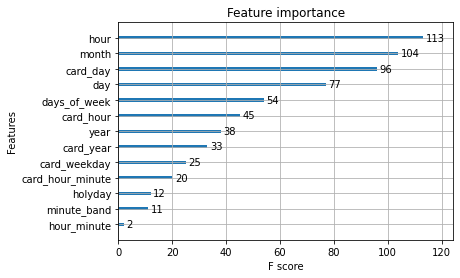

In [23]:
xgb.plot_importance(bst,max_num_features=20)

In [24]:
submission=pd.DataFrame({
    'store_id':range(200),
    'total_sales':0
})

In [25]:
for store in range(180):
    df=test[test.store_id==store].drop(['store_id','amount'],axis=1)
    X_test=xgb.DMatrix(df)

    pred=bst.predict(X_test)
    submission.loc[store,'total_sales']=np.sum(pred)
    print(f"store_id : {store} 끝.")

store_id : 0 끝.
store_id : 1 끝.
store_id : 2 끝.
store_id : 3 끝.
store_id : 4 끝.
store_id : 5 끝.
store_id : 6 끝.
store_id : 7 끝.
store_id : 8 끝.
store_id : 9 끝.
store_id : 10 끝.
store_id : 11 끝.
store_id : 12 끝.
store_id : 13 끝.
store_id : 14 끝.
store_id : 15 끝.
store_id : 16 끝.
store_id : 17 끝.
store_id : 18 끝.
store_id : 19 끝.
store_id : 20 끝.
store_id : 21 끝.
store_id : 22 끝.
store_id : 23 끝.
store_id : 24 끝.
store_id : 25 끝.
store_id : 26 끝.
store_id : 27 끝.
store_id : 28 끝.
store_id : 29 끝.
store_id : 30 끝.
store_id : 31 끝.
store_id : 32 끝.
store_id : 33 끝.
store_id : 34 끝.
store_id : 35 끝.
store_id : 36 끝.
store_id : 37 끝.
store_id : 38 끝.
store_id : 39 끝.
store_id : 40 끝.
store_id : 41 끝.
store_id : 42 끝.
store_id : 43 끝.
store_id : 44 끝.
store_id : 45 끝.
store_id : 46 끝.
store_id : 47 끝.
store_id : 48 끝.
store_id : 49 끝.
store_id : 50 끝.
store_id : 51 끝.
store_id : 52 끝.
store_id : 53 끝.
store_id : 54 끝.
store_id : 55 끝.
store_id : 56 끝.
store_id : 57 끝.
store_id : 58 끝.
store_i

In [26]:
submission

,store_id,total_sales
0,0,702438.437500
1,1,58952.265625
2,2,114725.312500
3,3,326892.031250
4,4,553732.062500
...,...,...
195,195,0.000000
196,196,0.000000
197,197,0.000000
198,198,0.000000


In [ ]:
# submission.to_csv('/content/drive/MyDrive/colab전용/submission_xgb_baseline.csv',index=False)